# Melanoma Detection using Convolutional Neural Network

# Problem Statement
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

#### Importing libraries

In [51]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob

In [ ]:
upload_from_google_drive = False

In [4]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [47]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [48]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [8]:
def load_images_local(path):
    list_of_files = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if name.endswith((".jpg")):
                list_of_files.append(name)

    return list_of_files

In [10]:
train_dir = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
test_dir = 'Skin cancer ISIC The International Skin Imaging Collaboration/Test/'

list_of_train_files = load_images_local(train_dir)
print(len(list_of_train_files))
list_of_test_files = load_images_local(test_dir)
print(len(list_of_test_files))

2239
118


#### Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

#### Create a dataset
Define some parameters for the loader:

In [12]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [13]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, labels='inferred', batch_size= batch_size, 
           image_size=(img_height,img_width), shuffle=True, seed=123, 
           validation_split=0.2, subset="training",interpolation='bilinear', follow_links=False)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [14]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, labels='inferred', batch_size= batch_size, 
           image_size=(img_height,img_width), shuffle=True, seed=123, 
           validation_split=0.2, subset="validation",interpolation='bilinear', follow_links=False)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [15]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### Visualizing Data

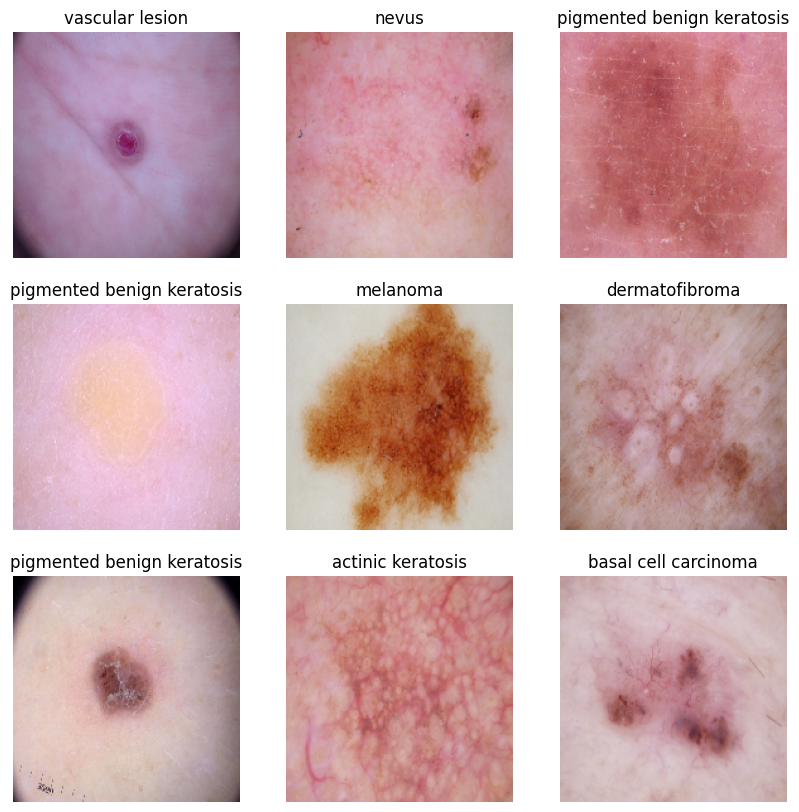

In [16]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Model Creation
Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use `layers.experimental.preprocessing.Rescaling` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [19]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [20]:
### Your code goes here
num_classes = 9

model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))])
# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu'))
# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# First Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2)))
# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
# softmax layer
model.add(Dense(num_classes, activation='softmax'))

#### Model Compilation
Choose an appropirate optimiser and loss function for model training

In [21]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 64)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 495616)            0         
                                                                 
 dense (Dense)               (None, 128)               63438976  
                                                        

#### Model Training

In [23]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


c:\Program Files\Python310\lib\site-packages\keras\src\backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 86s 1s/step - loss: 5.6367 - accuracy: 0.3002 - val_loss: 1.7495 - val_accuracy: 0.4161
Epoch 2/20
56/56 [==============================] - 82s 1s/step - loss: 1.5800 - accuracy: 0.4459 - val_loss: 1.4679 - val_accuracy: 0.4609
Epoch 3/20
56/56 [==============================] - 91s 2s/step - loss: 1.5691 - accuracy: 0.4448 - val_loss: 1.5955 - val_accuracy: 0.4877
Epoch 4/20
56/56 [==============================] - 86s 2s/step - loss: 1.4209 - accuracy: 0.5229 - val_loss: 1.5394 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 90s 2s/step - loss: 1.2040 - accuracy: 0.5910 - val_loss: 1.5969 - val_accuracy: 0.4877
Epoch 6/20
56/56 [==============================] - 89s 2s/step - loss: 0.9989 - accuracy: 0.6685 - val_loss: 1.5448 - val_accuracy: 0.5034
Epoch 7/20
56/56 [==============================] - 92s 2s/step - loss: 0.9364 - accuracy: 0.6858 - val_loss: 1.6888 - val_accuracy: 0.4966
Epoch 8/20
56/56 [=============

#### Visualizing the results

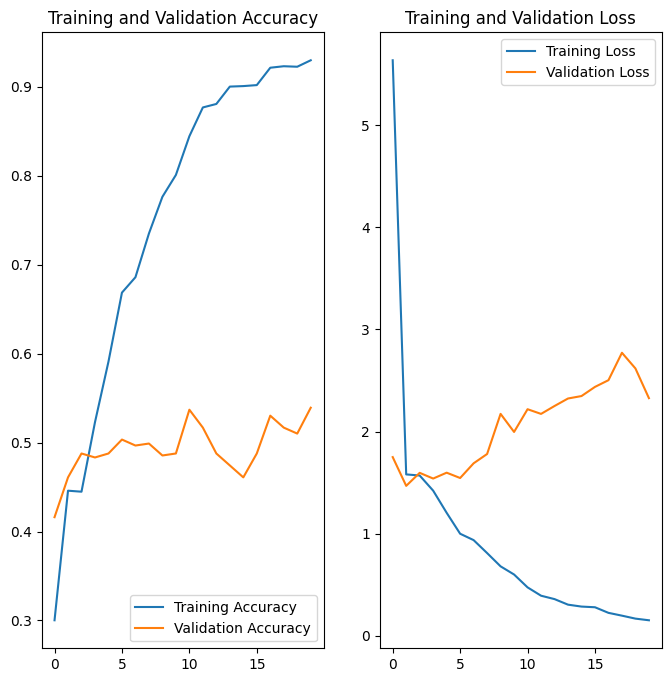

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Write your findings here

The model seems to have overfit the training data. It is clearly evident from the graphs shown above that the training accuracy has gone upto 95% while validation accuracy got stagnant at around 54%.

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

In [25]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

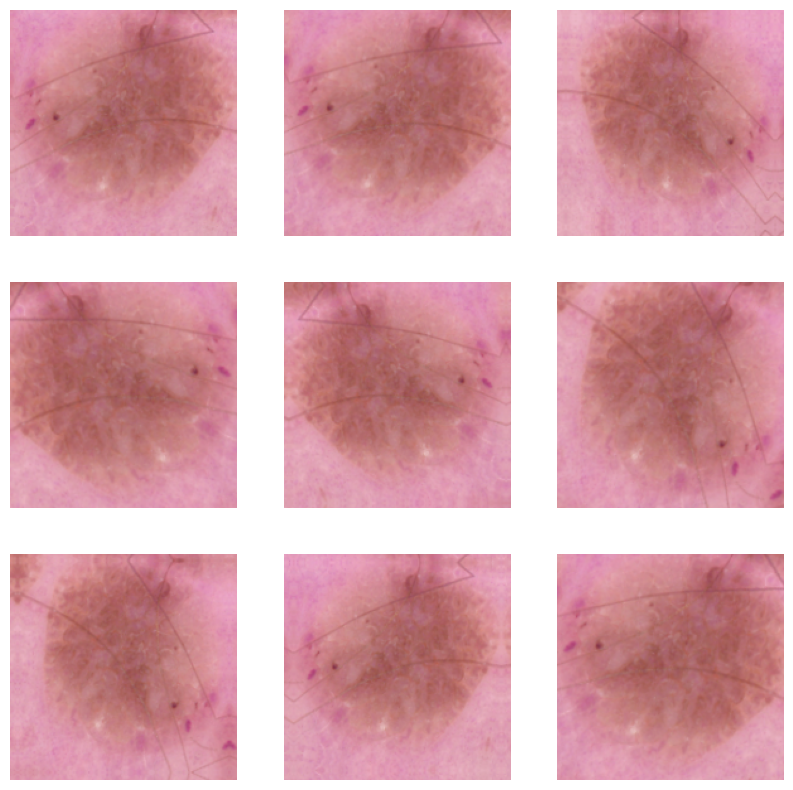

In [26]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Todo:
Create the model, compile and train the model

In [27]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Model Compilation

In [28]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

#### Model Training

In [29]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 19s 321ms/step - loss: 2.0426 - accuracy: 0.2349 - val_loss: 1.9458 - val_accuracy: 0.2125
Epoch 2/20
56/56 [==============================] - 19s 343ms/step - loss: 1.6757 - accuracy: 0.4023 - val_loss: 1.6960 - val_accuracy: 0.4497
Epoch 3/20
56/56 [==============================] - 20s 356ms/step - loss: 1.5346 - accuracy: 0.4548 - val_loss: 1.4412 - val_accuracy: 0.5213
Epoch 4/20
56/56 [==============================] - 20s 362ms/step - loss: 1.3971 - accuracy: 0.5128 - val_loss: 1.4022 - val_accuracy: 0.5324
Epoch 5/20
56/56 [==============================] - 20s 361ms/step - loss: 1.3869 - accuracy: 0.5117 - val_loss: 1.3779 - val_accuracy: 0.5436
Epoch 6/20
56/56 [==============================] - 21s 378ms/step - loss: 1.3131 - accuracy: 0.5363 - val_loss: 1.3520 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 21s 381ms/step - loss: 1.2885 - accuracy: 0.5374 - val_loss: 1.3363 - val_accuracy: 0.5257

#### Result Visualizations

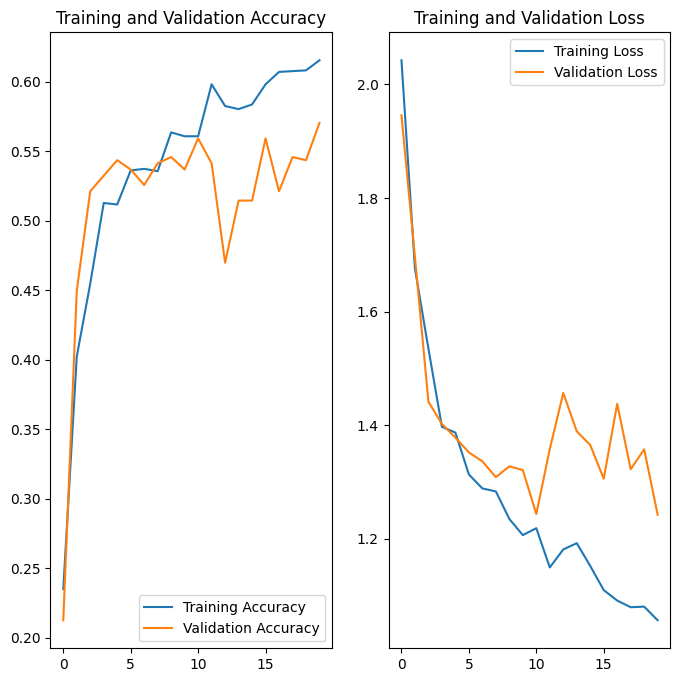

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

After data augmentation strategy and dropouts regularization, we found not much difference between the training and validation accuracy. Hence the model is not overfitted. However still the model accuracy is not very good.

Todo: Find the distribution of classes in the training dataset.

Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [44]:
for i in class_names:
  print(i)
  list_of_files_for_path = []
  path1 = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/' + i
  path2 = 'Skin cancer ISIC The International Skin Imaging Collaboration/Test/' + i
  files_for_path1 = load_images_local(path1)
  files_for_path2 = load_images_local(path2)
  list_of_files_for_path = files_for_path1 + files_for_path2
  print(len(list_of_files_for_path))

actinic keratosis
130
basal cell carcinoma
392
dermatofibroma
111
melanoma
454
nevus
373
pigmented benign keratosis
478
seborrheic keratosis
80
squamous cell carcinoma
197
vascular lesion
142


In [45]:
path_to_training_dataset= 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1BC18C37CD0>: 100%|██████████| 500/500 [00:01<00:00, 264.85 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1BC1899EFE0>: 100%|██████████| 500/500 [00:01<00:00, 260.33 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1BC1CAECB20>: 100%|██████████| 500/500 [00:02<00:00, 237.85 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1BC18C37D60>: 100%|██████████| 500/500 [00:11<00:00, 45.17 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x1BC194C8790>: 100%|██████████| 500/500 [00:11<00:00, 44.52 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1BC194AEC50>: 100%|██████████| 500/500 [00:02<00:00, 183.50 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1BC1CA29D20>: 100%|██████████| 500/500 [00:06<00:00, 81.25 Samples/s]                   


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1BC1CAAAC20>: 100%|██████████| 500/500 [00:02<00:00, 209.95 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1BC18A908B0>: 100%|██████████| 500/500 [00:02<00:00, 200.65 Samples/s]                  


In [49]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [52]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_53898f6e-5af6-4155-8a3e-1ade390ba1ce.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_66794398-e2a4-42ae-a494-97f4dc29ecc6.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7d7be2ab-0061-443e-bdba-8dbcbc6f9972.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_8a15a75c-6c7f-49f5-9a2b-eab7a2414687.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_9f2cd43a-403f-4aa7-b782-c69fd13d977d.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train

In [53]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [54]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [55]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [56]:
df2['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

#### Model Training on the data created using Augmentor

In [57]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [58]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [59]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Model Creation (make sure to include normalization)

In [60]:
## your code goes here
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))])
# first conv layer
model.add(Conv2D(16, kernel_size=(3, 3),activation='relu'))
# second conv layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# First Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2)))
# third conv layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# Second Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2)))
# dropout
model.add(Dropout(0.2))
# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
# softmax layer
model.add(Dense(num_classes, activation='softmax'))

#### Model Compilation

In [61]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 conv2d_6 (Conv2D)           (None, 176, 176, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 88, 88, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                 

#### Model Training

In [62]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


c:\Program Files\Python310\lib\site-packages\keras\src\backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 376s 2s/step - loss: 1.9706 - accuracy: 0.2852 - val_loss: 1.5122 - val_accuracy: 0.4491
Epoch 2/30
169/169 [==============================] - 374s 2s/step - loss: 1.4395 - accuracy: 0.4662 - val_loss: 1.2912 - val_accuracy: 0.5278
Epoch 3/30
169/169 [==============================] - 371s 2s/step - loss: 1.2162 - accuracy: 0.5525 - val_loss: 1.1353 - val_accuracy: 0.5843
Epoch 4/30
169/169 [==============================] - 364s 2s/step - loss: 1.0312 - accuracy: 0.6231 - val_loss: 1.0829 - val_accuracy: 0.5954
Epoch 5/30
169/169 [==============================] - 373s 2s/step - loss: 0.8630 - accuracy: 0.6929 - val_loss: 0.9827 - val_accuracy: 0.6370
Epoch 6/30
169/169 [==============================] - 370s 2s/step - loss: 0.7256 - accuracy: 0.7491 - val_loss: 0.8832 - val_accuracy: 0.7142
Epoch 7/30
169/169 [==============================] - 374s 2s/step - loss: 0.5643 - accuracy: 0.8047 - val_loss: 0.8782 - val_accuracy: 0.7454
Epoch 8/30

#### Data Visualization

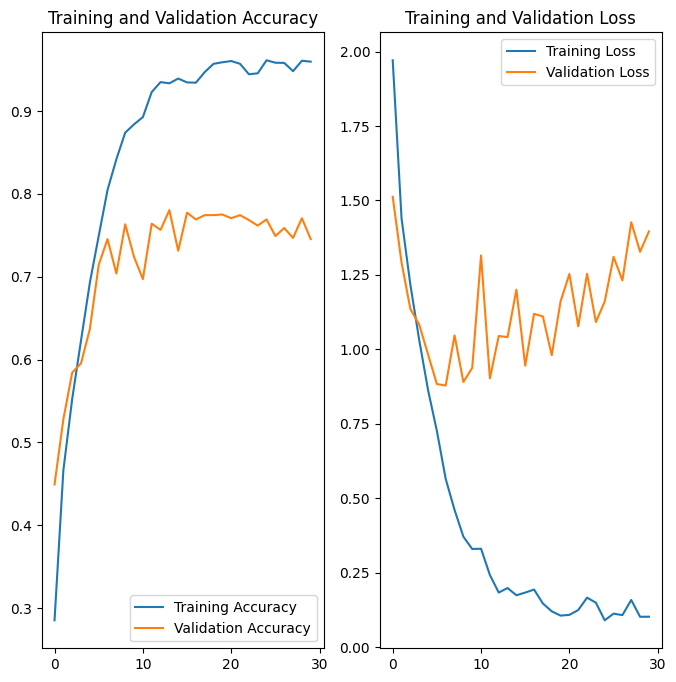

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo:** Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

### The model training and validation accuracy has increased after increasing the sample size. However there is still sign of overfitting which could be regularized using increasing dropouts
 